<h1> Script predicción</h1> 
<h2> The Backpropagation Boyz </h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

Comenzamos examinando el fichero original.

In [2]:
!wc Modelar_UH2022.txt

 21404829  42809657 825424331 Modelar_UH2022.txt


In [3]:
!head Modelar_UH2022.txt

ID|SAMPLETIME|READINGINTEGER|READINGTHOUSANDTH|DELTAINTEGER|DELTATHOUSANDTH
0|2019-06-13 08:34:09|369320|0|17|0
0|2019-06-13 17:34:10|369403|0|2|0
0|2019-06-13 18:34:10|369403|0|0|0
0|2019-06-13 04:34:10|369284|0|1|0
0|2019-06-13 14:34:10|369356|0|28|0
0|2019-06-13 01:34:09|369283|0|0|0
0|2019-06-13 16:34:10|369401|0|42|0
0|2019-06-13 10:34:09|369323|0|0|0
0|2019-06-13 22:34:08|369511|0|15|0


Vemos que cuenta con 21404829 muestras y que no se encuentran ordenadas. En primer lugar habrá que reducir el tamaño del dataset de alguna manera, ya que trabajar con tantas muestras supone un gran coste computacional. 

# Agrupar datos

In [4]:
# sort lines
!sort Modelar_UH2022.txt > Modelar_UH2022_sorted.txt
# move header to the top
!sed '1h;1d;$!H;$!d;G' Modelar_UH2022_sorted.txt > tmp.txt; mv tmp.txt Modelar_UH2022_sorted.txt
# remove file we are creating
!rm Modelar_UH2022_agg.txt

Creamos una versión del fichero que contenga los datos agrupados por días y con el valor entero y decimal en una misma variable.

In [5]:
file1 = open('Modelar_UH2022_sorted.txt', 'r')
file2 = open('Modelar_UH2022_agg.txt', 'a')
iden_pre = ""
curr_delta = 0
curr_reading = 0

for i, line in enumerate(file1.readlines()):
    if i != 0:
        iden, content  = line.split()
        content = content.split('|')

        if '' in content: content = ['0' if c == '' else c for c in content]

        if iden != iden_pre and i!= 1:

            file2.write(iden_pre+'|'+ str(curr_reading)+'|'+str(curr_delta)+'\n')
            curr_delta = 0

            
        curr_reading = int(content[1])*100 + int(content[2])*(10**(2-len(content[2])))

        curr_delta += int(content[3])*100 + int(content[4])*(10**(2-len(content[2])))

        iden_pre = iden

    else:
        file2.write('ID|SAMPLETIME|READING|DELTA\n')

file1.close()
file2.close()

In [6]:
# remove auxiliar file
!rm Modelar_UH2022_sorted.txt

# Carga y transformación a serie temporal

Leemos el fichero que acabamos de generar, ordenamos los datos y convertimos la columna de fecha a tipo datetime.

In [7]:
ds = pd.read_csv("Modelar_UH2022_agg.txt", sep='|')
print(ds.head)
print(ds.shape)

<bound method NDFrame.head of         ID  SAMPLETIME   READING  DELTA
0        0  2019-02-01  33195300  24300
1        0  2019-02-02  33218900  23600
2        0  2019-02-03  33252400  33500
3        0  2019-02-04  33277600  25200
4        0  2019-02-05  33299600  22000
...     ..         ...       ...    ...
890831   9  2020-01-26  25950600   8800
890832   9  2020-01-27  25965500  14900
890833   9  2020-01-28  25982100  16600
890834   9  2020-01-29  25992200  10100
890835   9  2020-01-30  26004400  12200

[890836 rows x 4 columns]>
(890836, 4)


In [8]:
ds = ds.sort_values(by=['ID', 'SAMPLETIME'])

In [9]:
ds['SAMPLETIME'] = pd.to_datetime(ds['SAMPLETIME'], infer_datetime_format=True)  

Mostramos la cantidad de muestras de cada depósito. Se puede apreciar como la mayoría tienen las 365, a los sumo un poco menos. Sin embargo las series del final carecen de bastantes muestras, hay algunos depositos que solo tenemos registros de cuatro días.

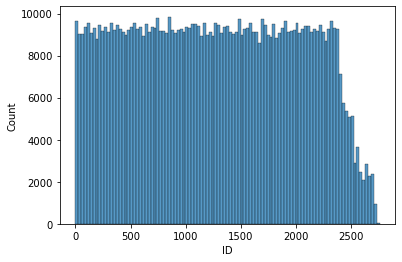

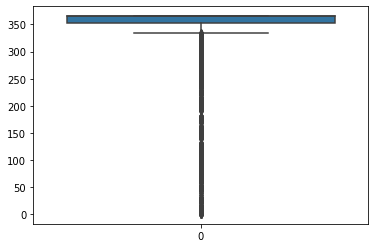

In [10]:
sns.histplot(ds, x='ID')
plt.show()
sns.boxplot(data=ds.groupby('ID').count()['SAMPLETIME'])
plt.show()
print("El deposito con menos registros tiene información de",ds.groupby('ID').count()['SAMPLETIME'].min(), "días")

Vamos a agrupar los datos por identificador para tener un array con las series temporales. Tendremos en cuenta la evolución del valor de delta.

In [11]:
ts = []
ids = []

for serie in ds['ID'].unique():
    if serie% 200 == 0 :print('reading serie:'+ str(serie))
    
    serie_samples = pd.Series(data=np.zeros(365),index=ds['SAMPLETIME'].unique())
    sample = ds.loc[ds['ID'] == serie, 'DELTA']
    sample.index = ds.loc[ds['ID'] == serie, 'SAMPLETIME']
    serie_samples.loc[ds.loc[(ds['ID'] == serie), 'SAMPLETIME']] = sample
    ts.append(serie_samples)
    ids.append(serie)

ts = np.array(ts)

reading serie:0
reading serie:20
reading serie:40
reading serie:60
reading serie:80
reading serie:100
reading serie:120
reading serie:140
reading serie:160
reading serie:180
reading serie:200
reading serie:220
reading serie:240
reading serie:260
reading serie:280
reading serie:300
reading serie:320
reading serie:340
reading serie:360
reading serie:380
reading serie:400
reading serie:420
reading serie:440
reading serie:460
reading serie:480
reading serie:500
reading serie:520
reading serie:540
reading serie:560
reading serie:580
reading serie:600
reading serie:620
reading serie:640
reading serie:660
reading serie:680
reading serie:700
reading serie:720
reading serie:740
reading serie:760
reading serie:780
reading serie:800
reading serie:820
reading serie:840
reading serie:860
reading serie:880
reading serie:900
reading serie:920
reading serie:940
reading serie:960
reading serie:980
reading serie:1000
reading serie:1020
reading serie:1040
reading serie:1060
reading serie:1080
reading ser

Mostramos las 10 primeras series por pantalla, con un `cumsum` de delta deberíamos obtener las mismas gráficas que mostrando gráficamente la columna de `READING`.

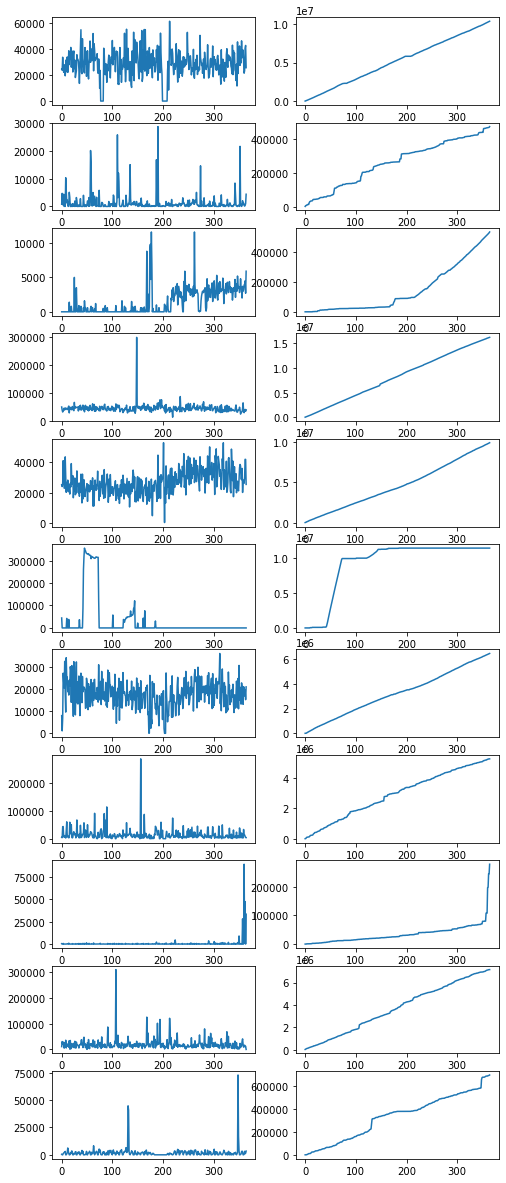

In [12]:
fig, ax = plt.subplots(11,2, figsize=(8,21))
for i in range(11):
    ax[i][0].plot(range(ts.shape[1]), ts[i,:])
    ax[i][1].plot(range(ts.shape[1]), np.cumsum(ts[i,:]))


Solo en las 10 primeras muestras se observan comportamientos muy diversos: depostios que gastan la misma cantidad de agua todos los días del años, otros que tan apenas se usan hasta que llega una determinada época, alguno presenta un consumo mediananmente constante y un día se dispara... Además hay que tener en cuenta el hecho de que no todas las series tienen la misma cantidad de muestras. De modo que será sensato hacer una agrupación de distintos tipos de series temporales.

# Clustering

In [13]:
from sklearn.model_selection import train_test_split
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
scaler = TimeSeriesScalerMeanVariance()
ts_norm = scaler.fit_transform(ts)

X_train, X_test, ind_train, ind_test, ids_train, ids_test = train_test_split(ts_norm, range(len(ts_norm)), 
                                                                             ids, test_size=0.8)


Estaría bien poder entrenar el modelo con todo el conjunto para dar con un resultado más preciso. Ahora bien, el coste temporal del algoritmo subiría a un ritmo demasiado acelerado. Por ello hemos tenido que dividir el conjunto en dos partes, la más pequeña construirá el modelo y a partir de ahí obtendremos todas las etiquetas.

In [14]:
km = TimeSeriesKMeans(n_clusters=10, metric="dtw")
y_train = km.fit_predict(X_train)

In [15]:
y_test = km.predict(X_test)

In [16]:
ind = np.concatenate([ind_train, ind_test])
ids2 = np.concatenate([ids_train, ids_test])
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Comprobamos que el número de elementos por cluster esté bien equilibrado, que no haya clusters de una decena de elementos u otros sintomas de un mal entrenamiento.

In [17]:
n = 10
for yi in range(n):
    print(sum(y == yi))

209
205
284
83
408
331
103
174
384
566


En principio parece que ha distribuido bien las muestras. Ahora mostraremos los elementos de cada cluster por pantalla, tanto normalizados como sin normalizar.

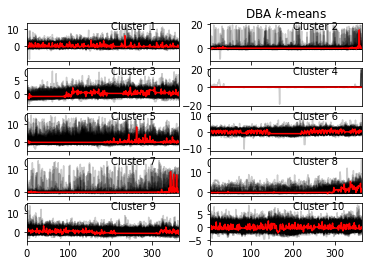

In [18]:
for yi in range(n):
    plt.subplot(int(n/2), 2, yi+1)
    for xx in X_test[yi == y_test]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 365)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

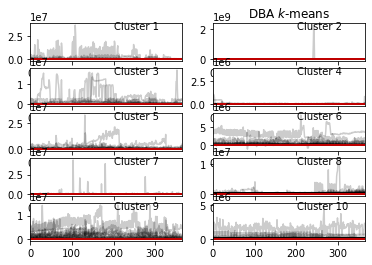

In [19]:
for yi in range(n):
    plt.subplot(int(n/2), 2, yi+1)
    for xx in ts[ind[y == yi]]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 365)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

Para cada cluster veremos su distribución por día de la semana, mes y año.

In [20]:
def EDA(ds):
    plt.figure(figsize=(30,10))

    ds['DAY'] = ds['SAMPLETIME'].dt.day
    ds['MONTH'] = ds['SAMPLETIME'].dt.month
    ds['WEEKDAY'] = ds['SAMPLETIME'].dt.weekday
    
    plt.subplot(1, 3, 1)
    sns.barplot("DAY","DELTA", data = ds)
    
    plt.subplot(1, 3, 2)
    sns.barplot("MONTH","DELTA", data = ds)
    
    plt.subplot(1, 3, 3)
    sns.barplot("WEEKDAY","DELTA", data = ds)
    
    plt.show()   

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

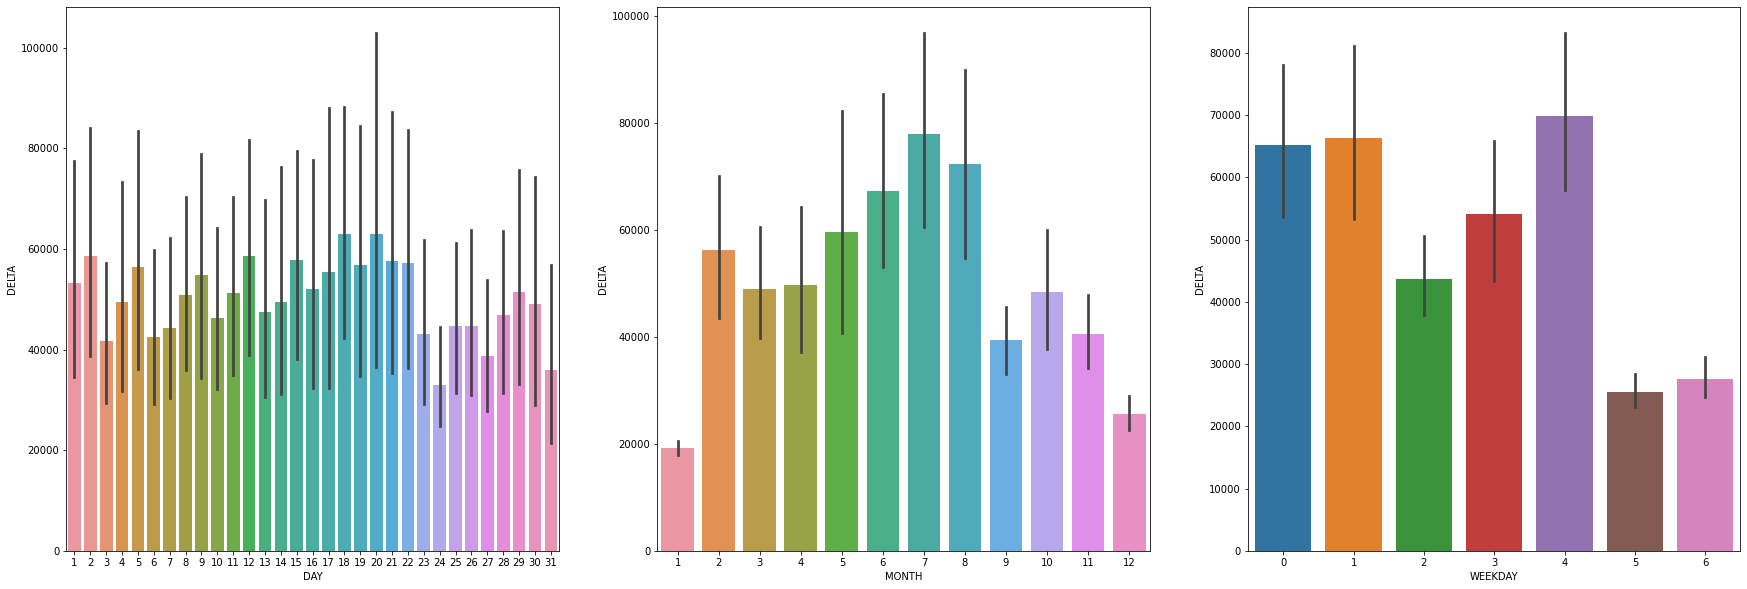

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

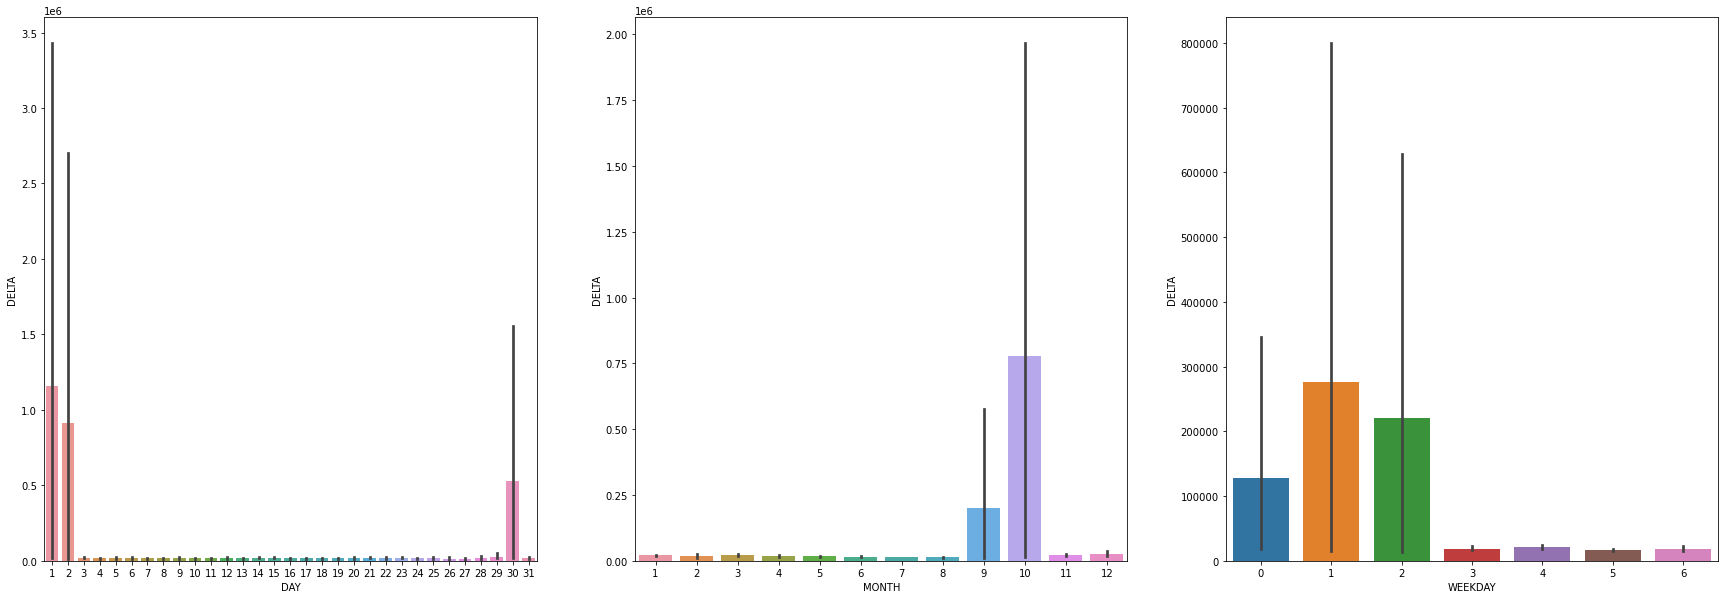

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

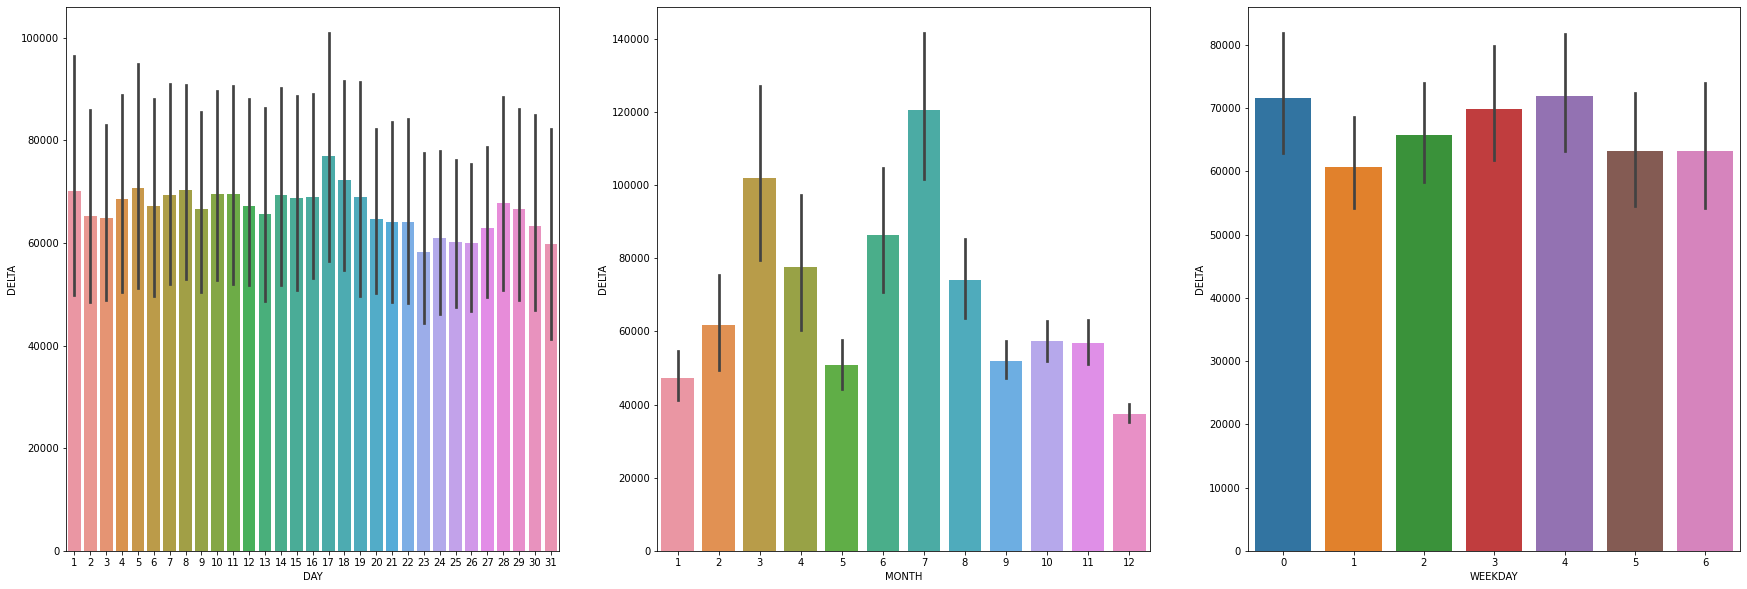

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

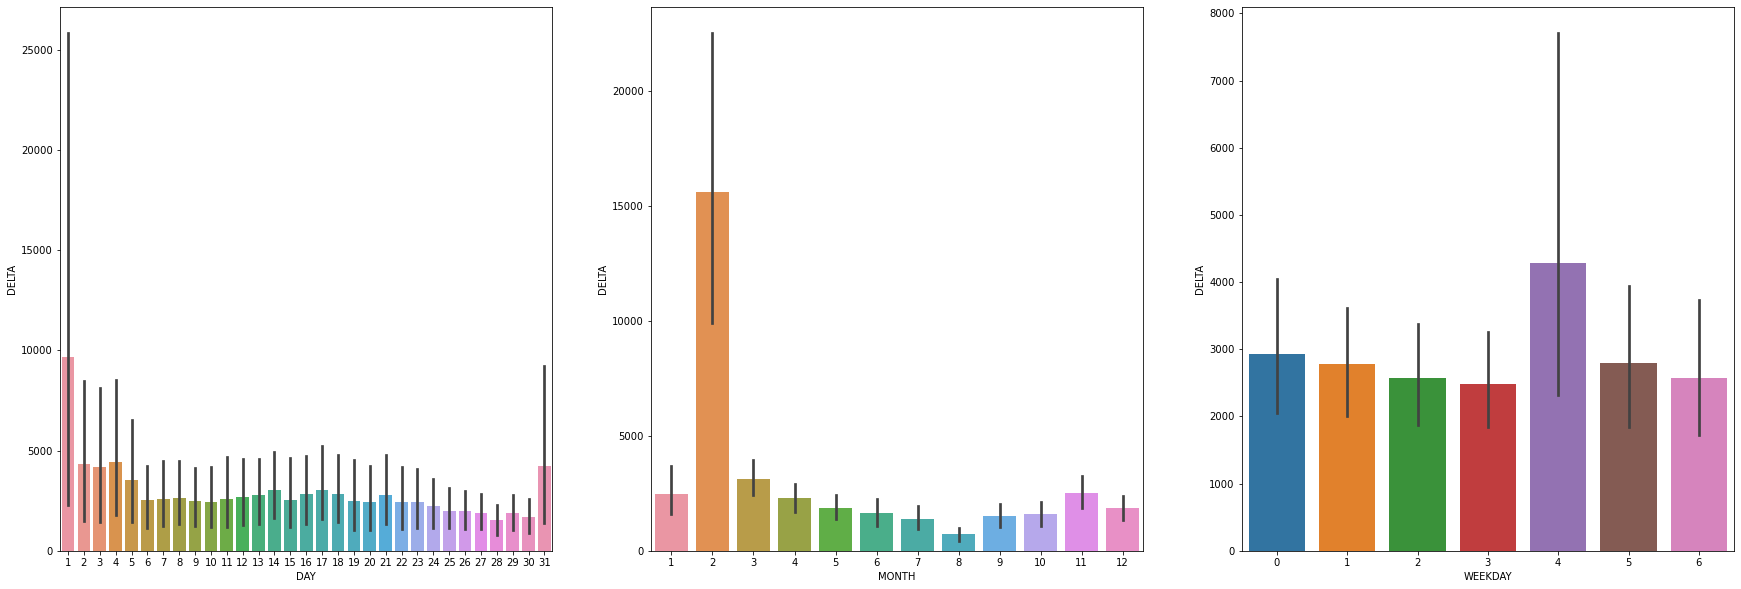

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

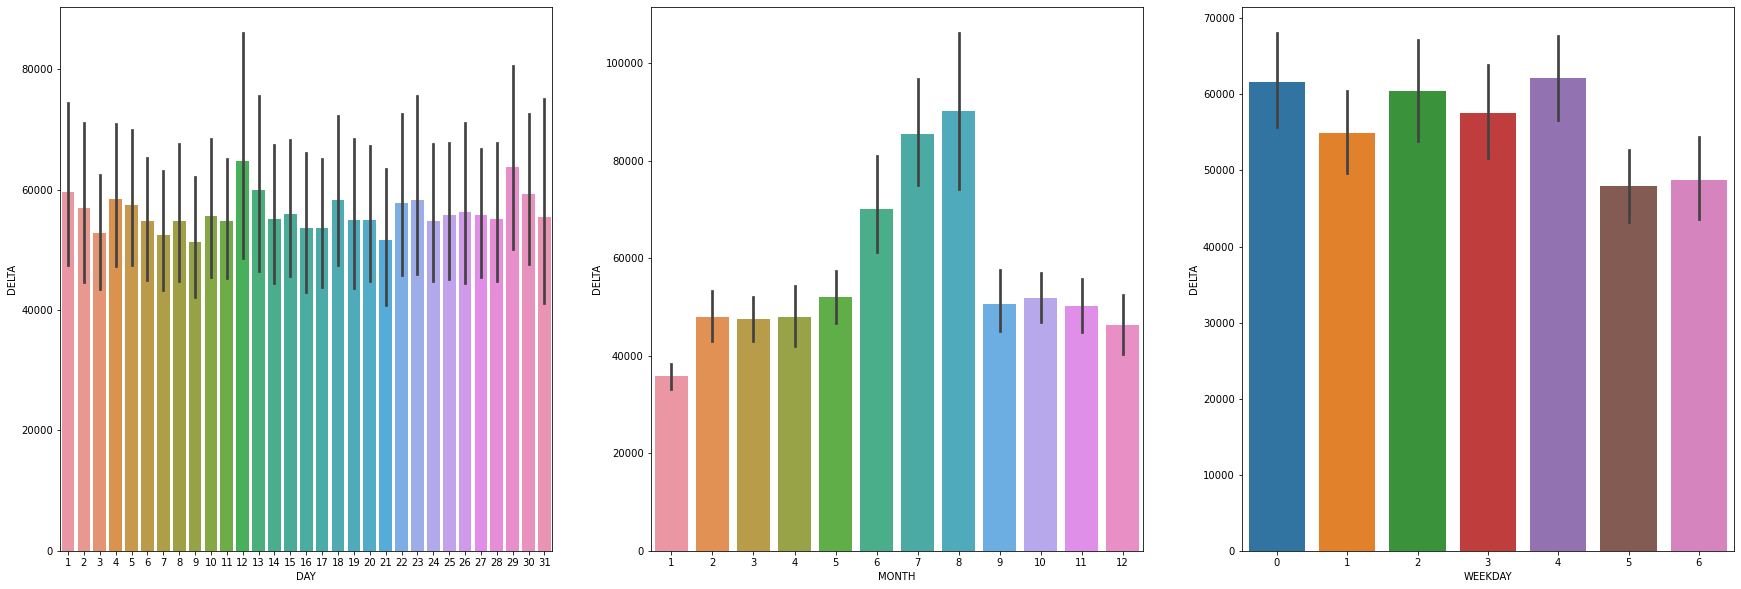

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

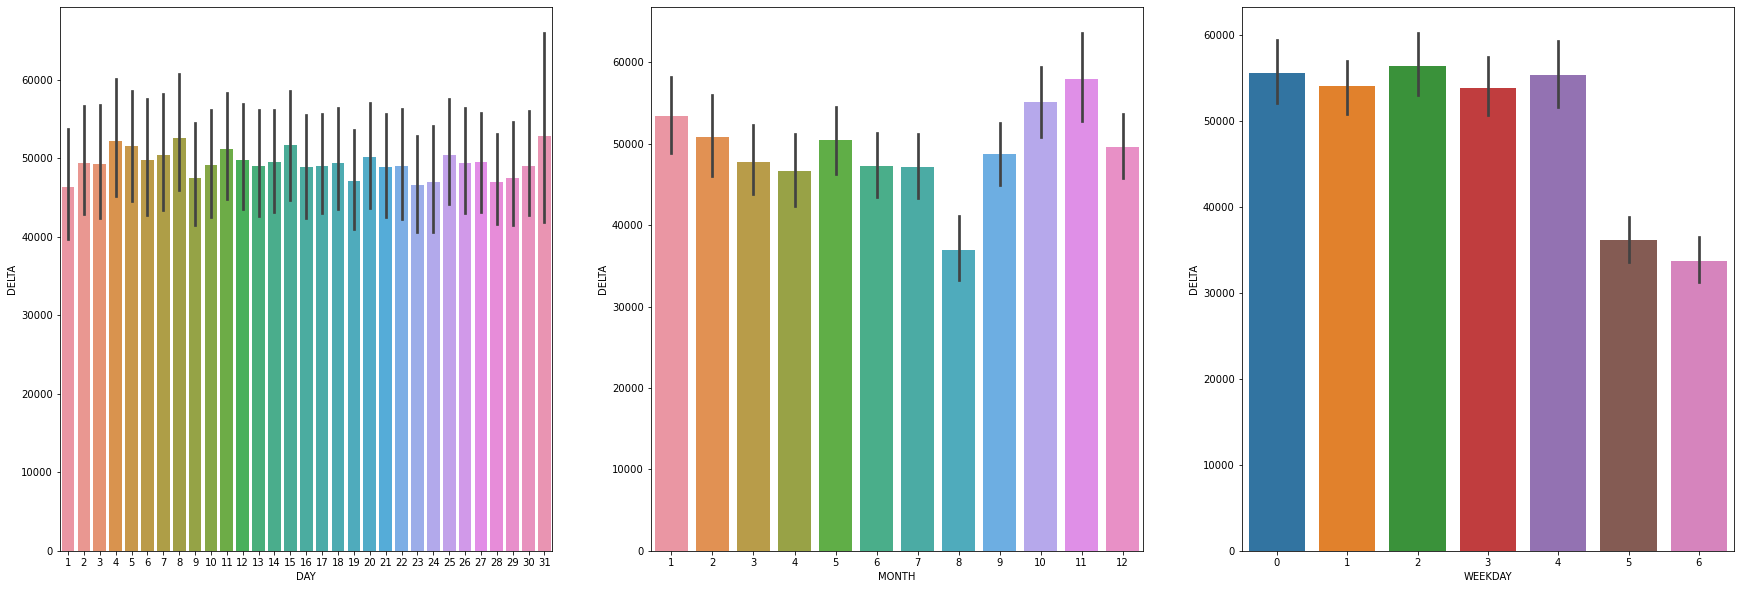

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

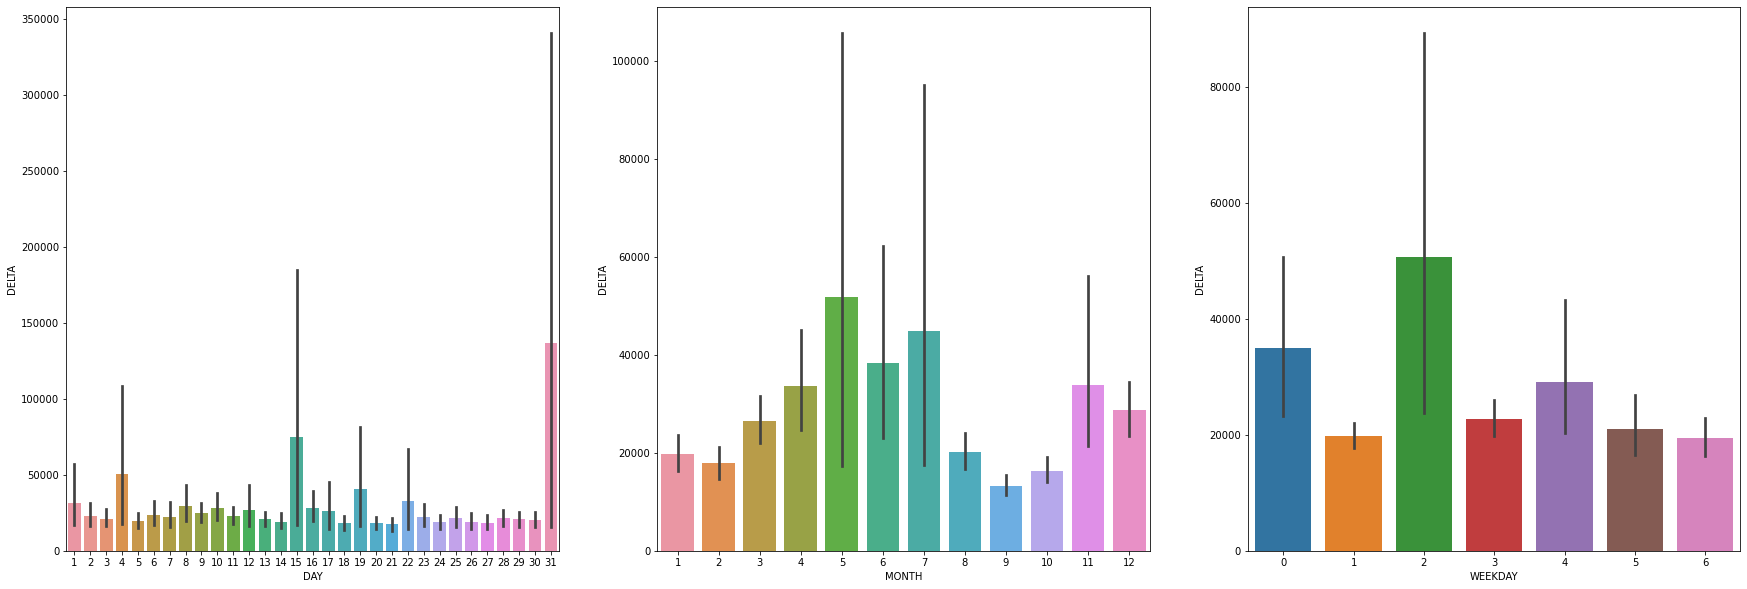

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

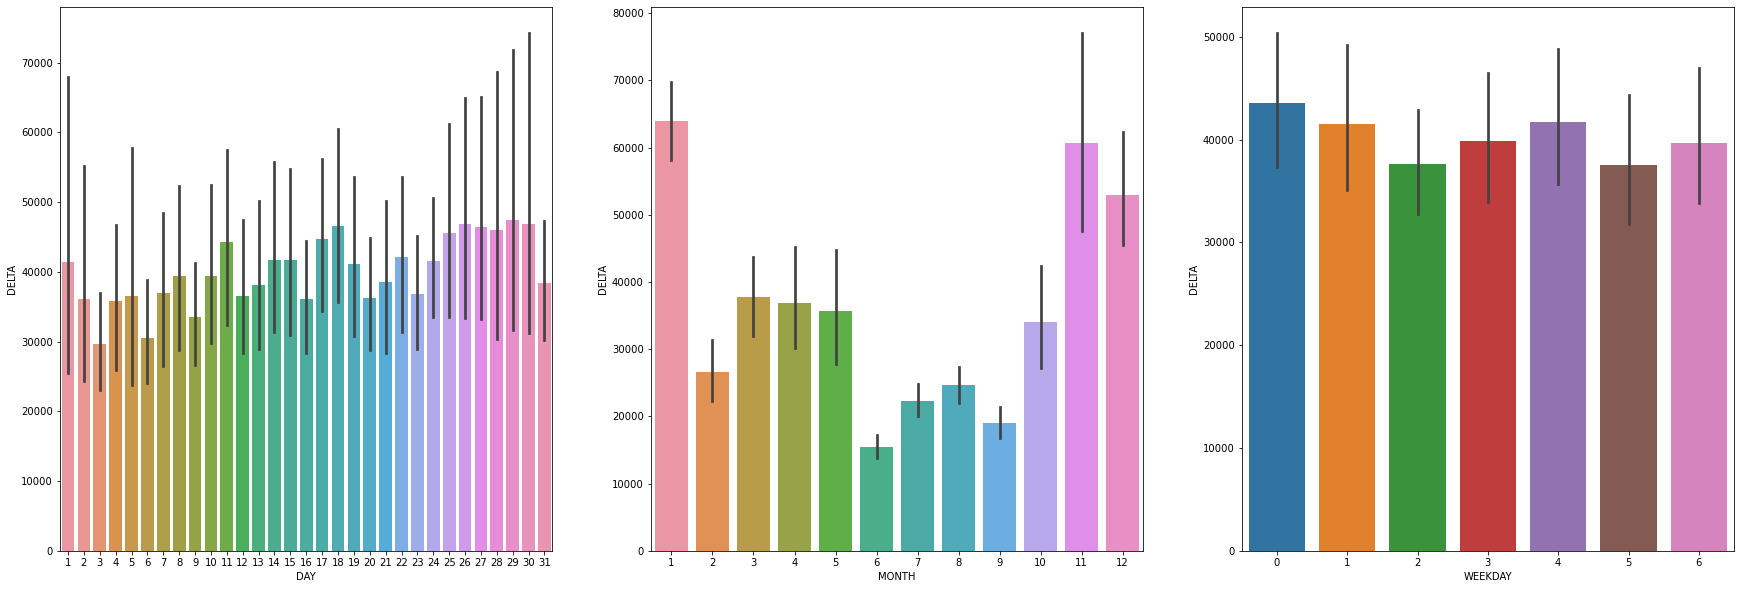

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

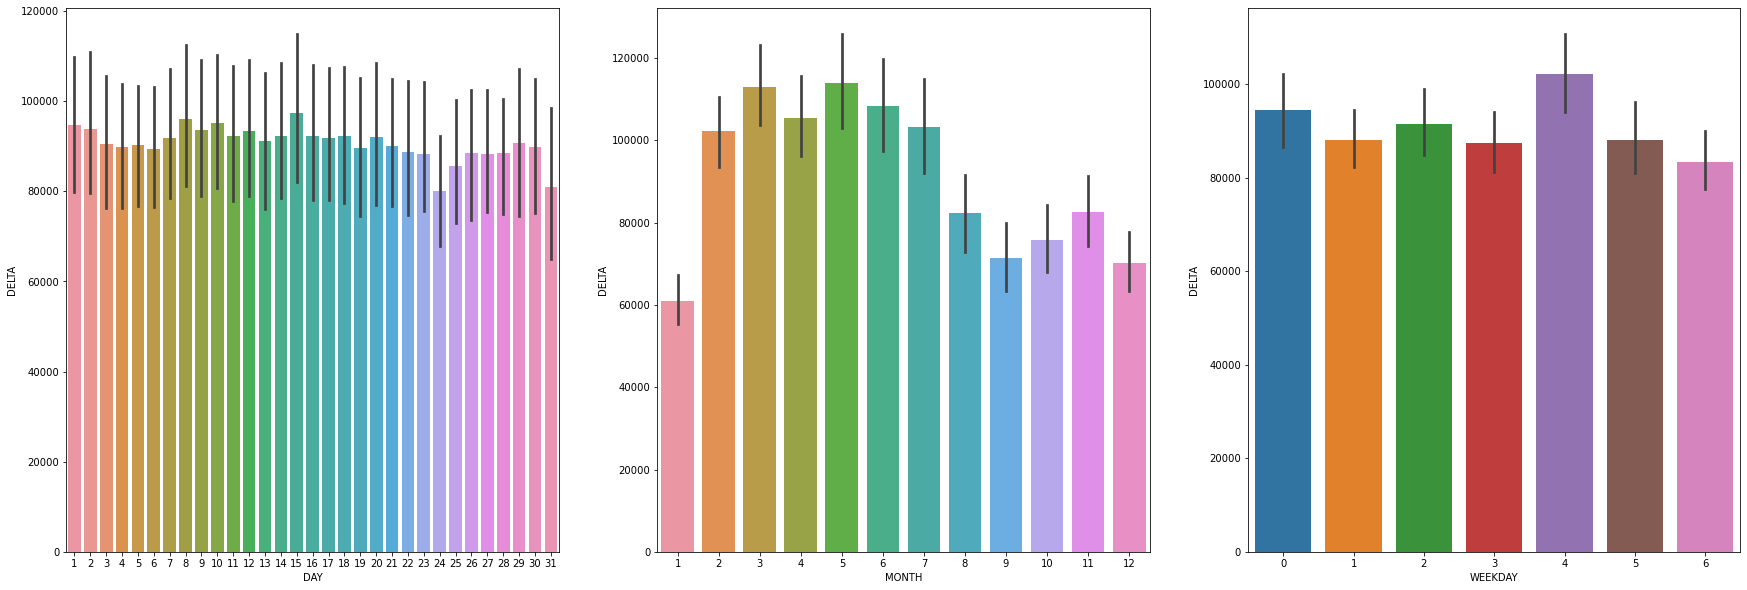

/tmp/ipykernel_2749/4272792384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['DAY'] = ds['SAMPLETIME'].dt.day
/tmp/ipykernel_2749/4272792384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['MONTH'] = ds['SAMPLETIME'].dt.month
/tmp/ipykernel_2749/4272792384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

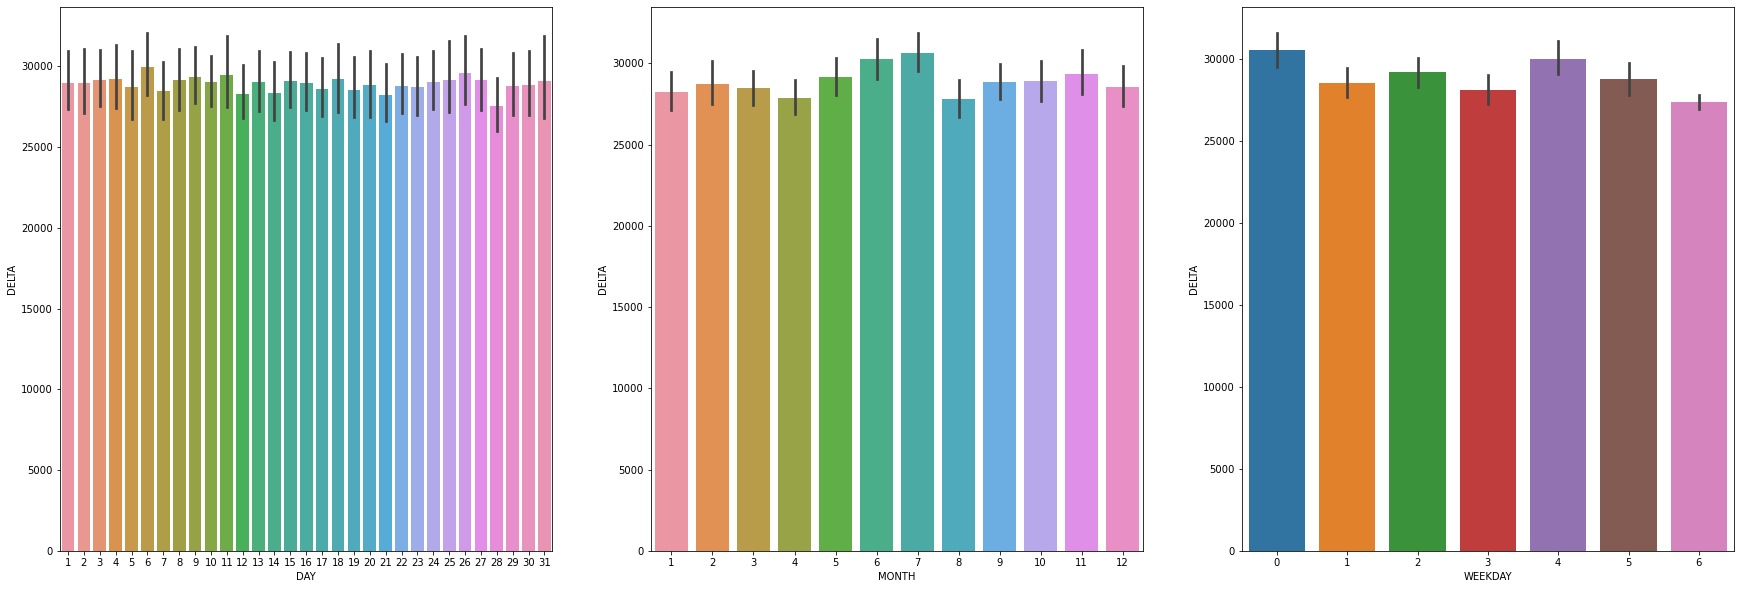

In [21]:
for yi in range(n):
    EDA(ds[ds['ID'].isin(ids2[y == yi])])

Finalmente calcularemos el coeficiente de silhouette y lo representaremos gráficamente.

In [22]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
silhouette_score(X_train, y_train, metric="dtw")

0.06946615044701661

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  4 22:34:16 2022

@author: morte
"""
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from pylab import *

def draw_silhouette(X_,cluster_labels):
    #Función que dibuja el silouette plot y devuelve los valores medios por cluster en orden.
    #Tambíen dibuja el valor medio con una línea discontínua.
    #
    #X_:- Matriz de datos que ha sido usada para clusterizar [muestras, características]
    #cluster_labels:-Etiquetas resultantes de la clusterización (vector)
    #
    #return, shiluete medio de cada cluster
    
    avg_sil_list = list()
    n_clusters = np.max(cluster_labels)
    X_ = X_.reshape([2747, 365])
    
    samples = silhouette_samples(X_,cluster_labels)
    y_lower = 10
    
    fig,ax=plt.subplots()
    silhouette_avg = silhouette_score(X_, cluster_labels)#silouette medio de todos los clústers
    
    #Dibujamos los diferenes clústers
    for i in range(n_clusters+1):
        it_sample = samples[cluster_labels == i]
        it_sample.sort()
        
        size_it_sample = it_sample.shape[0]
        y_upper = y_lower + size_it_sample
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            it_sample,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,)
    
        ax.text(-0.05, y_lower + 0.5 * size_it_sample, str(i))
        
        y_lower = y_upper+10
        print("cluster "+str(i)+" = "+str(np.mean(it_sample)))
        
        avg_sil_list.append(np.mean(it_sample))
    
    #Establecemos los retoques para que el gráfico sea legible
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")   
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])   
    
    return(avg_sil_list)

cluster 0 = -0.2399709043020893
cluster 1 = -0.24209546121342457
cluster 2 = -0.09615547846965788
cluster 3 = 0.7332511743776405
cluster 4 = -0.2414768221115059
cluster 5 = -0.20969322298287335
cluster 6 = -0.2391935971261866
cluster 7 = -0.172589262381913
cluster 8 = -0.22120817683007185
cluster 9 = -0.23742028783679267


[-0.2399709043020893,
 -0.24209546121342457,
 -0.09615547846965788,
 0.7332511743776405,
 -0.2414768221115059,
 -0.20969322298287335,
 -0.2391935971261866,
 -0.172589262381913,
 -0.22120817683007185,
 -0.23742028783679267]

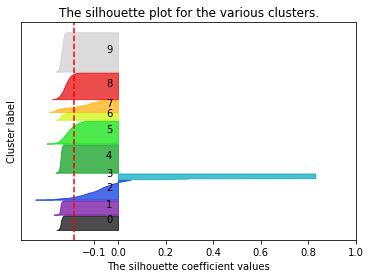

In [24]:
draw_silhouette(X, y)

A la vista de los resultados parece que esta solución no es la más ideonea para el problema que se nos plantea. Por ello en el modelo final utilizaremos un clustering jerárquico para agrupar los conjuntos.